### Step 1: Install and Import Necessary Libraries
In this step, we will install and import the necessary libraries for data processing and geospatial analysis. These include `pandas` for data handling, `numpy` for numerical operations, and `geopy` for distance calculations.


In [27]:
import sys
sys.path.append('/Users/radhikasethi/Documents/github/data-512-Final-Project')


In [34]:
%pip install geopy
%pip install pyproj
%pip install tqdm
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pyproj import Transformer, Geod
from geopy.distance import geodesic
from tqdm import tqdm
from wildfire.Reader import Reader 


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative Commons CC-BY license.


### Step 2: Set File Paths and Parameters
Define the path to the dataset, set Boulder, CO coordinates, and define filtering parameters such as distance and year range.


In [28]:
# Path to the combined wildfire dataset
input_file = "/Users/radhikasethi/Documents/github/data-512-Final-Project/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json"

# Coordinates for Boulder, CO
boulder_coords = (40.02, -105.25)

# Filtering parameters
max_distance = 650  # miles
start_year = 1961
end_year = 2021
fire_type = "Wildfire"


### Step 3: Define Helper Functions
These functions convert fire perimeter coordinates from ESRI:102008 to EPSG:4326 and calculate the shortest distance from Boulder to each fire perimeter.


In [35]:
# Convert ring data from ESRI:102008 to EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    # Using pyproj transformer for coordinate conversion
    to_epsg4326 = Transformer.from_crs("ESRI:102008", "EPSG:4326")
    # Transform each ESRI:102008 x,y coordinate into decimal degree lat, lon
    for coord in ring_data:
        lat, lon = to_epsg4326.transform(coord[0], coord[1])
        new_coord = lat, lon
        converted_ring.append(new_coord)
    return converted_ring

# Calculate the shortest distance from Boulder to the fire perimeter
def shortest_distance_from_place_to_fire_perimeter(place=None, ring_data=None):
    ring = convert_ring_to_epsg4326(ring_data)
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    
    for point in ring:
        # Calculate the distance
        d = geodcalc.inv(place[1], place[0], point[1], point[0])
        # Convert distance to miles
        distance_in_miles = d[2] * 0.00062137
        
        # Save if it's the closest point
        if not closest_point or closest_point[0] > distance_in_miles:
            closest_point = [distance_in_miles, point]
    return closest_point

# Calculate average distance from Boulder to fire perimeter
def average_distance_from_place_to_fire_perimeter(place=None, ring_data=None):
    ring = convert_ring_to_epsg4326(ring_data)
    geodcalc = Geod(ellps='WGS84')
    distances_in_meters = [geodcalc.inv(place[1], place[0], point[1], point[0])[2] for point in ring]
    distances_in_miles = [meters * 0.00062137 for meters in distances_in_meters]
    # Remove duplicate points
    distances_in_miles_no_dup = distances_in_miles[1:]
    # Return average miles
    average = sum(distances_in_miles_no_dup) / len(distances_in_miles_no_dup)
    return average


### Step 4: Load and Filter Data Based on Distance and Year
This step iterates through each feature, filtering for fires within 650 miles of Boulder and within the year range 1961–2021. Only wildfires are considered.


### Step 4a: Verify Data Loading with `Reader` Class
To ensure the `Reader` class is working as expected, we’ll perform a simple test to load and display a few entries from the JSON file. This will help us verify that the file path is correct and that the data structure matches our expectations.


In [42]:

input_file = "/Users/radhikasethi/Documents/github/data-512-Final-Project/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json"
boulder = (40.02, -105.25)
distance_threshold = 650.0


In [43]:
# Step 3: Initialize Variables and Data Reader

# Initialize list to hold fires within the specified distance
fires_within_distance = []

# Initialize counters for total features and invalid geometries
feature_count = 0
invalid_geometry_count = 0

# Set up the Reader to process the JSON data
reader_stream = Reader(input_file)
feature_stream = reader_stream.next()

# Display a message about the filtering process starting
print("Starting wildfire data filtering based on distance from Boulder...")


Starting wildfire data filtering based on distance from Boulder...


In [44]:
# Path to the dataset
input_file = "/Users/radhikasethi/Documents/github/data-512-Final-Project/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json"

# Initialize Reader
try:
    reader_stream = Reader(input_file)
    feature_stream = reader_stream.next()
    
    # Test: Print details of the first few entries
    print("Testing data loading with Reader class...")
    test_count = 0
    while feature_stream and test_count < 5:  # Limit to 5 entries
        # Print keys and some sample values
        print(f"\nEntry {test_count + 1}")
        print("Attributes:", feature_stream.get('attributes', 'No attributes found'))
        print("Geometry:", feature_stream.get('geometry', 'No geometry found'))
        
        # Move to the next entry and increment test counter
        feature_stream = reader_stream.next()
        test_count += 1
    
    print("\nData loading test complete.")

except Exception as e:
    print("Error loading data with Reader:", e)


Testing data loading with Reader class...

Entry 1
Attributes: {'OBJECTID': 1, 'USGS_Assigned_ID': 1, 'Assigned_Fire_Type': 'Wildfire', 'Fire_Year': 1860, 'Fire_Polygon_Tier': 1, 'Fire_Attribute_Tiers': '1 (1)', 'GIS_Acres': 3940.20708940724, 'GIS_Hectares': 1594.5452365353703, 'Source_Datasets': 'Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)', 'Listed_Fire_Types': 'Wildfire (1)', 'Listed_Fire_Names': 'Big Quilcene River (1)', 'Listed_Fire_Codes': 'No code provided (1)', 'Listed_Fire_IDs': '', 'Listed_Fire_IRWIN_IDs': '', 'Listed_Fire_Dates': 'Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)', 'Listed_Fire_Causes': '', 'Listed_Fire_Cause_Class': 'Undetermined (1)', 'Listed_Rx_Reported_Acres': None, 'Listed_Map_Digitize_Methods': 'Other (1)', 'Listed_Notes': '', 'Processing_Notes': '', 'Wildfire_Notice': 'Wildfire mapping prior to 1984 was inconsistent, infrequent, and done without the aid of more modern fire mapping methods (GPS and satellite imagery). Areas 

In [45]:
fires_within_650_miles = []
invalid_data_count = 0
curve_ring_count = 0

In [46]:
# Step 4: Process and Filter Wildfire Data by Distance to Boulder

from tqdm import tqdm

# Initialize list to store filtered wildfire data
fires_within_radius = []

# Set up tqdm for dynamic progress tracking
with tqdm() as pbar:
    while feature_stream:
        try:
            # Update progress bar
            pbar.update(1)
            
            # Fetch year and geometry information
            year = feature_stream['attributes'].get('Fire_Year')
            if year and year >= 1963:  # Only process records from 1963 onwards
                if 'rings' in feature_stream['geometry']:
                    ring_data = feature_stream['geometry']['rings'][0]

                    # Calculate the shortest distance to Boulder
                    distance_info = shortest_distance_from_place_to_fire_perimeter(boulder, ring_data)
                    if distance_info[0] <= distance_threshold:
                        # Append to list if within the threshold distance
                        fire_data = feature_stream['attributes']
                        fire_data['Distance'] = distance_info[0]
                        fire_data['Closest_Point'] = distance_info[1]
                        fires_within_radius.append(fire_data)
                        
                        # Print debug statement when a wildfire is found within radius
                        #print(f"Wildfire within {distance_threshold} miles of Boulder found. Distance: {distance_info[0]:.2f} miles.")
        
        except Exception as e:
            # Handle any errors, such as invalid geometries
            print(f"Error processing feature {feature_count}: {e}")
        
        # Fetch the next feature
        feature_stream = reader_stream.next()

print("Processing complete.")
print(f"Total wildfires within {distance_threshold} miles of Boulder: {len(fires_within_radius)}")


135056it [33:42, 66.77it/s] 

Processing complete.
Total wildfires within 650.0 miles of Boulder: 37105


# Extended Dataset: All Fires within 1800 Miles of Boulder

This code retrieves all fires (not limited to wildfires) within an 1800-mile radius of Boulder, CO, from 1963 onwards. By adjusting the `distance_threshold` to 1800 miles, we expand the scope of the data to include all fire types and ensure coverage up to the maximum specified distance. This dataset will allow us to create a more comprehensive histogram, as requested, showing fire occurrences across greater distances from Boulder.

The output is saved in a separate JSON file (`boulder_1800fires_final.json`) for further analysis and visualization.


In [76]:
# Import necessary modules
from tqdm import tqdm

# Path to the dataset
input_file = "/Users/radhikasethi/Documents/github/data-512-Final-Project/GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json"

# Load data using the Reader class
try:
    reader_stream = Reader(input_file)
    feature_stream = reader_stream.next()
    
    # Testing data loading with Reader class
    print("Testing data loading with Reader class...")
    test_count = 0
    while feature_stream and test_count < 5:  # Limit to 5 entries
        print(f"\nEntry {test_count + 1}")
        print("Attributes:", feature_stream.get('attributes', 'No attributes found'))
        print("Geometry:", feature_stream.get('geometry', 'No geometry found'))
        
        # Move to the next entry and increment test counter
        feature_stream = reader_stream.next()
        test_count += 1
    
    print("\nData loading test complete.")

except Exception as e:
    print("Error loading data with Reader:", e)

# Step: Process and Filter All Fires within 1800 Miles of Boulder

# Define Boulder coordinates and extended distance threshold
boulder = [40.02, -105.25]  # Approximate coordinates for Boulder, CO
distance_threshold_extended = 1800  # 1800 miles

# Initialize list to store filtered fire data
all_fires_within_radius = []

# Reset the reader to start from the beginning of the data stream
reader_stream = Reader(input_file)
feature_stream = reader_stream.next()

# Set up tqdm for dynamic progress tracking
with tqdm() as pbar:
    while feature_stream:
        try:
            # Update progress bar
            pbar.update(1)
            
            # Fetch year and geometry information
            year = feature_stream['attributes'].get('Fire_Year')
            if year and year >= 1963:  # Only process records from 1963 onwards
                if 'rings' in feature_stream['geometry']:
                    ring_data = feature_stream['geometry']['rings'][0]

                    # Calculate the shortest distance to Boulder
                    distance_info = shortest_distance_from_place_to_fire_perimeter(boulder, ring_data)
                    if distance_info[0] <= distance_threshold_extended:
                        # Append to list if within the extended threshold distance
                        fire_data = feature_stream['attributes']
                        fire_data['Distance'] = distance_info[0]
                        fire_data['Closest_Point'] = distance_info[1]
                        all_fires_within_radius.append(fire_data)
        
        except Exception as e:
            # Handle any errors, such as invalid geometries
            print(f"Error processing feature: {e}")
        
        # Fetch the next feature
        feature_stream = reader_stream.next()

# Processing complete, save results to JSON
output_path = "/Users/radhikasethi/Documents/github/data-512-Final-Project/boulder_1800fires_final.json"
with open(output_path, 'w') as file:
    json.dump(all_fires_within_radius, file, indent=4)

print("Processing complete.")
print(f"Total fires within 1800 miles of Boulder: {len(all_fires_within_radius)}")
print(f"Data saved to {output_path}")


Testing data loading with Reader class...

Entry 1
Attributes: {'OBJECTID': 1, 'USGS_Assigned_ID': 1, 'Assigned_Fire_Type': 'Wildfire', 'Fire_Year': 1860, 'Fire_Polygon_Tier': 1, 'Fire_Attribute_Tiers': '1 (1)', 'GIS_Acres': 3940.20708940724, 'GIS_Hectares': 1594.5452365353703, 'Source_Datasets': 'Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)', 'Listed_Fire_Types': 'Wildfire (1)', 'Listed_Fire_Names': 'Big Quilcene River (1)', 'Listed_Fire_Codes': 'No code provided (1)', 'Listed_Fire_IDs': '', 'Listed_Fire_IRWIN_IDs': '', 'Listed_Fire_Dates': 'Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)', 'Listed_Fire_Causes': '', 'Listed_Fire_Cause_Class': 'Undetermined (1)', 'Listed_Rx_Reported_Acres': None, 'Listed_Map_Digitize_Methods': 'Other (1)', 'Listed_Notes': '', 'Processing_Notes': '', 'Wildfire_Notice': 'Wildfire mapping prior to 1984 was inconsistent, infrequent, and done without the aid of more modern fire mapping methods (GPS and satellite imagery). Areas 

135061it [34:16, 65.69it/s] 


Processing complete.
Total fires within 1800 miles of Boulder: 113252
Data saved to /Users/radhikasethi/Documents/github/data-512-Final-Project/boulder_1800fires_final.json


### Step 5: Save Filtered Data to JSON
Save the filtered dataset to a JSON file to avoid reprocessing the full dataset in future steps.


In [47]:

output_file = "/Users/radhikasethi/Documents/github/data-512-Final-Project/boulder_fires_final.json"

# Save the filtered wildfire data to JSON
with open(output_file, 'w') as f:
    json.dump(fires_within_radius, f, indent=4)

print(f"Filtered data saved to {output_file}. Total records saved: {len(fires_within_radius)}")

Filtered data saved to /Users/radhikasethi/Documents/github/data-512-Final-Project/boulder_fires_final.json. Total records saved: 37105


# US EPA Air Quality System API Setup
This notebook provides step-by-step code to set up and access the US EPA Air Quality System (AQS) API. The example covers:
- Requesting an API key.
- Retrieving parameters and sensor data.
- Accessing monitoring site data by county and bounding box.
- Pulling daily summary air quality data.

## License
Developed by Dr. David W. McDonald for DATA 512, UW MS Data Science. Provided under the Creative Commons CC-BY license.


## Step 1: Requesting an API Key
Before using the AQS API, you must request an API key. This can be done once by providing your email. The EPA will send an email with your API key, which you will need to access data.


In [48]:
import requests
import json
import time

# Constants
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'
API_ACTION_SIGNUP = '/signup?email={email}'

AQS_REQUEST_TEMPLATE = {
    "email": "",     
    "key": "",      
    "state": "",     
    "county": "",     
    "begin_date": "",    
    "end_date": "",     
    "minlat": 0.0,
    "maxlat": 0.0,
    "minlon": 0.0,
    "maxlon": 0.0,
    "param": "",    
    "pclass": ""      
}

# Function to sign up for an API key
def request_signup(email_address=None, endpoint_url=API_REQUEST_URL, endpoint_action=API_ACTION_SIGNUP):
    if not email_address:
        raise Exception("Email is required to sign up.")
    request_url = endpoint_url + endpoint_action.format(email=email_address)
    response = requests.get(request_url)
    return response.json()

# Replace with your email to request an API key (comment after the first run)
email = "rsethi3@uw.edu"
print("Requesting API key...")
response = request_signup(email)
print(json.dumps(response, indent=4))


Requesting API key...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2024-10-30T11:50:04-04:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=rsethi3@uw.edu"
        }
    ],
    "Data": [
        "You should receive a registration confirmation email with a link for confirming your email shortly."
    ]
}


In [54]:
import requests
import time
# 
#  Root URL for the AQS API
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

# API Actions for specific requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'

# Setting rate limit and latency assumptions
API_LATENCY_ASSUMED = 0.002  # 2ms assumed latency
API_THROTTLE_WAIT = (1.0 / 100.0) - API_LATENCY_ASSUMED  # to stay within 100 requests per minute

# User credentials
USERNAME = "rsethi3@uw.edu"
APIKEY = "saffronhare17"


In [55]:
# AQS request template for standardized parameters
AQS_REQUEST_TEMPLATE = {
    "email":      USERNAME,     
    "key":        APIKEY,      
    "state":      "",     
    "county":     "",     
    "begin_date": "",     
    "end_date":   "",     
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     
    "pclass":    ""      
}


In [52]:
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'

def request_list_info(email, key, endpoint_url=API_REQUEST_URL, endpoint_action=API_ACTION_LIST_CLASSES):
    request_url = endpoint_url + endpoint_action.format(email=email, key=key)
    response = requests.get(request_url)
    return response.json()

# Retrieve and print parameter classes
response = request_list_info(USERNAME, APIKEY)
print("Available parameter classes:")
print(json.dumps(response, indent=4))


Available parameter classes:
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2024-10-30T12:24:50-04:00",
            "url": "https://aqs.epa.gov/data/api/list/classes?email=rsethi3@uw.edu&key=saffronhare17",
            "rows": 27
        }
    ],
    "Data": [
        {
            "code": "AIRNOW MAPS",
            "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
        },
        {
            "code": "ALL",
            "value_represented": "Select all Parameters Available"
        },
        {
            "code": "AQI POLLUTANTS",
            "value_represented": "Pollutants that have an AQI Defined"
        },
        {
            "code": "CORE_HAPS",
            "value_represented": "Urban Air Toxic Pollutants"
        },
        {
            "code": "CRITERIA",
            "value_represented": "Criteria Pollutants"
        },
        {
            "code": "CSN DART",
            "value_represe

In [56]:
# Function to retrieve AQI Pollutants parameters
def request_aqi_parameters(email, key, param_class="AQI POLLUTANTS"):
    request_url = f"{API_REQUEST_URL}{API_ACTION_LIST_PARAMS.format(email=email, key=key, pclass=param_class)}"
    response = requests.get(request_url)
    return response.json()

# Get AQI pollutants
response = request_aqi_parameters(USERNAME, APIKEY)
print("AQI pollutant parameters:")
print(json.dumps(response, indent=4))


AQI pollutant parameters:
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2024-10-30T13:02:01-04:00",
            "url": "https://aqs.epa.gov/data/api/list/parametersByClass?email=rsethi3@uw.edu&key=saffronhare17&pc=AQI%20POLLUTANTS",
            "rows": 7
        }
    ],
    "Data": [
        {
            "code": "42101",
            "value_represented": "Carbon monoxide"
        },
        {
            "code": "42401",
            "value_represented": "Sulfur dioxide"
        },
        {
            "code": "42602",
            "value_represented": "Nitrogen dioxide (NO2)"
        },
        {
            "code": "44201",
            "value_represented": "Ozone"
        },
        {
            "code": "81102",
            "value_represented": "PM10 Total 0-10um STP"
        },
        {
            "code": "88101",
            "value_represented": "PM2.5 - Local Conditions"
        },
        {
            "code": "88502",
            "v

In [57]:
# Define parameter codes for AQI pollutants based on response data
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"  # CO, SO2, NO2, Ozone
AQI_PARAMS_PARTICULATES = "81102,88101,88502"  # PM10, PM2.5, Acceptable PM2.5


In [58]:
# Define the FIPS codes for Boulder, CO
state_code = "08"  # Colorado
county_code = "013"  # Boulder

# Function to request monitoring sites by county
def request_monitoring_sites(email, key, state_code, county_code):
    request_url = f"{API_REQUEST_URL}{API_ACTION_LIST_SITES.format(email=email, key=key, state=state_code, county=county_code)}"
    response = requests.get(request_url)
    return response.json()

# Retrieve monitoring sites for Boulder County
response = request_monitoring_sites(USERNAME, APIKEY, state_code, county_code)
print("Monitoring sites in Boulder County:")
print(json.dumps(response, indent=4))


Monitoring sites in Boulder County:
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2024-10-30T13:36:04-04:00",
            "url": "https://aqs.epa.gov/data/api/list/sitesByCounty?email=rsethi3@uw.edu&key=saffronhare17&state=08&county=013",
            "rows": 26
        }
    ],
    "Data": [
        {
            "code": "0001",
            "value_represented": null
        },
        {
            "code": "0002",
            "value_represented": null
        },
        {
            "code": "0003",
            "value_represented": "LONGMONT - MUNICIPAL BLDG"
        },
        {
            "code": "0004",
            "value_represented": null
        },
        {
            "code": "0005",
            "value_represented": null
        },
        {
            "code": "0006",
            "value_represented": null
        },
        {
            "code": "0007",
            "value_represented": "Eldora Ski Area"
        },
        {
        


 ## Function to Fetch Daily AQI Data by County
 Retrieves daily AQI summary data by county and date range, structured in a way to handle large date ranges.


In [60]:


def request_daily_summary(email_address, key, param, begin_date, end_date, state, county):
    request_url = f"{API_REQUEST_URL}{API_ACTION_DAILY_SUMMARY_COUNTY.format(email=email_address, key=key, param=param, begin_date=begin_date, end_date=end_date, state=state, county=county)}"
    response = requests.get(request_url)
    return response.json()


## Function to Extract and Structure Response Data
 This function parses the response data and structures it for easier data handling and future analysis.


In [61]:

EXTRACTION_FIELDS = ['sample_duration', 'observation_count', 'arithmetic_mean', 'aqi']

def extract_summary_from_response(response, fields=EXTRACTION_FIELDS):
    result = {}
    data = response.get("Data", [])
    
    for record in data:
        site = record['site_number']
        param = record['parameter_code']
        date = record['date_local'].replace('-', '')  # Format as YYYYMMDD
        
        if site not in result:
            result[site] = {
                'local_site_name': record['local_site_name'],
                'site_address': record['site_address'],
                'state': record['state'],
                'county': record['county'],
                'city': record['city'],
                'pollutant_type': {}
            }
        
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = {
                'parameter_name': record['parameter'],
                'units_of_measure': record['units_of_measure'],
                'method': record['method'],
                'data': {}
            }
        
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = []
        
        extracted_data = {k: record.get(k) for k in fields}
        result[site]['pollutant_type'][param]['data'][date].append(extracted_data)
    
    return result



 ## Fetch and Store Particulate AQI Data for Boulder, CO
 Loop through each year and request daily AQI data, storing the results in a structured list.

In [62]:



# Define parameters for Boulder, CO
state_code = "08"  # Colorado
county_code = "013"  # Boulder

# Path for saving JSON data
output_path = "/Users/radhikasethi/Documents/github/data-512-Final-Project/particulate_data.json"

# Initialize list for storing data
particulate_data = []
start_year = 1963
end_year = 2023

# Fetch data for each year and store results
for year in range(start_year, end_year + 1):
    begin_date = f"{year}0101"
    end_date = f"{year}1231"

    response = request_daily_summary(USERNAME, APIKEY, AQI_PARAMS_PARTICULATES, begin_date, end_date, state_code, county_code)
    
    # Process response if successful
    if response["Header"][0]['status'] == "Success":
        extracted_data = extract_summary_from_response(response)
        particulate_data.append(extracted_data)
    elif response["Header"][0]['status'].startswith("No data"):
        print(f"No data for year: {year}")
    else:
        print(f"Error retrieving data for year: {year}")

# Save particulate data to JSON file
with open(output_path, 'w') as file:
    json.dump(particulate_data, file, indent=4)
print(f"Data saved to {output_path}")


No data for year: 1963
No data for year: 1964
No data for year: 1965
No data for year: 1966
No data for year: 1967
No data for year: 1968
No data for year: 1969
No data for year: 1970
No data for year: 1971
No data for year: 1972
No data for year: 1973
No data for year: 1974
No data for year: 1975
No data for year: 1976
No data for year: 1977
No data for year: 1978
No data for year: 1979
No data for year: 1980
No data for year: 1981
No data for year: 1982
No data for year: 1983
No data for year: 1984
Data saved to /Users/radhikasethi/Documents/github/data-512-Final-Project/particulate_data.json



 ## Fetch and Store Gaseous AQI Data for Boulder, CO
 Loop through each year to request daily AQI data for gaseous pollutants.


In [63]:

# Define request data template for gaseous pollutants
request_data_gaseous = AQS_REQUEST_TEMPLATE.copy()
request_data_gaseous['email'] = USERNAME
request_data_gaseous['key'] = APIKEY
request_data_gaseous['param'] = AQI_PARAMS_GASEOUS
request_data_gaseous['state'] = "08"  # Colorado
request_data_gaseous['county'] = "013"  # Boulder

# Initialize list to store gaseous AQI data
gaseous_data = []
start_year = 1963
end_year = 2023

# Fetching data for each year and storing results
for year in range(start_year, end_year + 1):
    begin_date = f"{year}0101"
    end_date = f"{year}1231"
    
    # Fetch AQI data for gaseous pollutants
    gaseous_aqi = request_daily_summary(USERNAME, APIKEY, AQI_PARAMS_GASEOUS, begin_date, end_date, "08", "013")
    
    # Check for successful response
    if gaseous_aqi["Header"][0]['status'] == "Success":
        extract_gaseous = extract_summary_from_response(gaseous_aqi)
        gaseous_data.append(extract_gaseous)
    elif gaseous_aqi["Header"][0]['status'].startswith("No data"):
        print(f"No data for year: {year}")
    else:
        print(f"Error retrieving data for year: {year}")

# Save gaseous AQI data to JSON
with open("/Users/radhikasethi/Documents/github/data-512-Final-Project/gaseous_data.json", 'w') as file:
    json.dump(gaseous_data, file, indent=4)
print("Gaseous data saved as JSON.")


No data for year: 1963
No data for year: 1964
No data for year: 1965
No data for year: 1966
No data for year: 1967
No data for year: 1968
No data for year: 1969
No data for year: 1970
No data for year: 1971
No data for year: 1972
No data for year: 1973
No data for year: 1974
Gaseous data saved as JSON.



 ## Define Helper Functions to Extract and Process AQI Data
`fetch_aqi` helps in extracting the AQI values and `process_gaseous_particulate` structures the data.



In [64]:

def fetch_aqi(data, dynamic_keys=None):
    if dynamic_keys is None:
        dynamic_keys = []
    extracted_data = []
    for key in data.keys():
        current_keys = dynamic_keys + [key]
        if isinstance(data[key], dict):
            extracted_data.extend(fetch_aqi(data[key], current_keys))
        elif isinstance(data[key], list):
            for item in data[key]:
                if isinstance(item, dict):
                    aqi = item.get("aqi")
                    sample_duration = item.get("sample_duration")
                    if aqi is not None:
                        extracted_data.append({"keys": current_keys, "sample_duration": sample_duration, "aqi": aqi})
    return extracted_data

def process_gaseous_particulate(input_df):
    processed_data = []
    for entry in input_df:
        keys = entry['keys']
        date = keys[-1]
        aqi = entry['aqi']
        sample_duration = entry['sample_duration']
        pollutant_type = keys[-3]
        processed_data.append({'Date': date, 'AQI': aqi, 'Sample_Duration': sample_duration, 'Pollutant_Type': pollutant_type})
    return processed_data



 ## Process and Save Particulate and Gaseous AQI Data
 This section structures data, creates DataFrames, and saves to CSV.



In [65]:

# Process particulate data
extracted_data_particulate = []
for record in particulate_data:
    extracted_data_particulate.extend(fetch_aqi(record))

particulate_df = pd.DataFrame(process_gaseous_particulate(extracted_data_particulate))
particulate_df['Date'] = pd.to_datetime(particulate_df['Date'], format='%Y%m%d')
particulate_df.to_csv("/Users/radhikasethi/Documents/github/data-512-Final-Project/aqi_particulate.csv", index=False)

# Process gaseous data
extracted_data_gaseous = []
for record in gaseous_data:
    extracted_data_gaseous.extend(fetch_aqi(record))

gaseous_df = pd.DataFrame(process_gaseous_particulate(extracted_data_gaseous))
gaseous_df['Date'] = pd.to_datetime(gaseous_df['Date'], format='%Y%m%d')
gaseous_df.to_csv("/Users/radhikasethi/Documents/github/data-512-Final-Project/aqi_gaseous.csv", index=False)

print("Particulate and gaseous data saved to CSV.")


Particulate and gaseous data saved to CSV.



 ## Aggregate and Calculate Yearly Averages
 Aggregate AQI values by date and calculate yearly averages.


In [66]:

# Drop unnecessary columns
particulate_df_copy = particulate_df.copy()
gaseous_df_copy = gaseous_df.copy()
particulate_df_copy.drop(['Sample_Duration', 'Pollutant_Type'], axis=1, inplace=True)
gaseous_df_copy.drop(['Sample_Duration', 'Pollutant_Type'], axis=1, inplace=True)

# Aggregate by date and take mean AQI
part_avg_df = particulate_df_copy.groupby('Date').mean().reset_index(drop=False)
gas_avg_df = gaseous_df_copy.groupby('Date').mean().reset_index(drop=False)

# Merge the two DataFrames and calculate max AQI for each date
merged_df = pd.merge(gas_avg_df, part_avg_df, on='Date', how='outer', suffixes=('_g', '_p'))
merged_df['AQI'] = merged_df[['AQI_g', 'AQI_p']].max(axis=1)
merged_df.drop(columns=['AQI_g', 'AQI_p'], inplace=True)

# Calculate yearly averages
merged_df['Year'] = merged_df['Date'].dt.year
aqi_df = merged_df.groupby('Year')['AQI'].mean().reset_index()

# Save the yearly AQI averages to CSV
aqi_df.to_csv("/Users/radhikasethi/Documents/github/data-512-Final-Project/aqi_yoy.csv", index=False)
print("Yearly AQI averages saved to CSV.")


Yearly AQI averages saved to CSV.


### Step 1: Load Data and Preview

In this step, we will load the Boulder fire data from the JSON file and select the relevant columns for the smoke impact calculation. We’ll preview the data to ensure the necessary columns (`Fire_Year`, `GIS_Acres`, and `Distance`) are available for processing.


In [68]:
# Load necessary libraries
import pandas as pd

# Load the Boulder fire data
fire_data_path = "/Users/radhikasethi/Documents/github/data-512-Final-Project/boulder_fires_final.json"
df_with_smoke = pd.read_json(fire_data_path)

# Select and preview relevant columns
df_with_smoke = df_with_smoke[['Fire_Year', 'GIS_Acres', 'Distance']]
df_with_smoke.head()


,Fire_Year,GIS_Acres,Distance
0,1963,40992.458271,646.762797
1,1963,45527.210986,641.523417
2,1963,10395.010334,583.827891
3,1963,9983.605738,635.193768
4,1963,9674.175812,508.783120


### Step 2: Calculate Smoke Impact

To estimate the smoke impact from wildfires near Boulder, we use a formula based on two primary factors:

1. **Size of the Fire (GIS Acres):** 
   - The size of a fire directly influences the volume of smoke produced. Larger fires release more particulate matter and pollutants, increasing the potential smoke impact. To account for this, we convert acres into a metric that allows for comparison across fires of different sizes.

2. **Distance from Boulder:** 
   - The closer a fire is to Boulder, the more likely it is that smoke will reach and affect the city’s air quality. Therefore, the inverse relationship with distance is included in the formula, where a closer fire has a greater impact than a distant one.

Our final formula, representing the smoke estimate, is:

\[
\text{Smoke Impact} = \frac{\text{GIS Acres} \times 15.625}{\text{Distance}}
\]

- **GIS Acres** is multiplied by a conversion factor of 15.625 to translate acres into a relative square mileage metric, making it compatible with our calculations.
- **Distance** is in miles, directly impacting the smoke impact inversely, as closer fires exert a stronger effect on Boulder.

This formula allows us to create a standardized smoke estimate, combining fire size and proximity. It enables a comparison with AQI values and provides a yearly assessment of smoke impact based on available wildfire data.


In [69]:
# Calculate smoke impact using the formula
df_with_smoke['Smoke_Impact'] = df_with_smoke['GIS_Acres'] * 15.625 / df_with_smoke['Distance']

# Preview the results
df_with_smoke[['Fire_Year', 'GIS_Acres', 'Distance', 'Smoke_Impact']].head()


,Fire_Year,GIS_Acres,Distance,Smoke_Impact
0,1963,40992.458271,646.762797,990.327774
1,1963,45527.210986,641.523417,1108.864700
2,1963,10395.010334,583.827891,278.201913
3,1963,9983.605738,635.193768,245.584651
4,1963,9674.175812,508.783120,297.099080


### Step 4: Save the Smoke Impact Data

To facilitate comparisons with the AQI data, we save the yearly smoke impact estimates to a CSV file. This allows for further analysis and visualization in the next steps.


In [71]:
# Save the smoke estimate DataFrame to CSV
df_with_smoke.to_csv("/Users/radhikasethi/Documents/github/data-512-Final-Project/Smoke_Estimate_Annual.csv", index=False)
print("Smoke impact data saved to CSV.")


Smoke impact data saved to CSV.


### Step 5: Comparison with AQI Data

With both smoke impact estimates and AQI data saved to CSV files, we are now ready to compare these datasets. This comparison can provide insights into how the smoke estimates align with or differ from the AQI readings over the years, helping us assess the smoke’s environmental impact.


### Visualization 1: Histogram of Fires by Distance from Boulder with Modeling Distance Cut-off
This histogram shows the number of fires occurring within every 50-mile interval from Boulder, Colorado, for all fires up to 1800 miles away. A vertical line indicates the distance cut-off (650 miles) for our modeling work, which focuses on fires within this range to estimate smoke impact.


apologies for this part, since we were asked to calculate the smoke estimates only till 650miles from our city, that is how i filtered the original data when I was trying to get the data for all wildfires in Colorado Boulder. 



   OBJECTID  USGS_Assigned_ID Assigned_Fire_Type  Fire_Year  \
0     14299             14299           Wildfire       1963   
1     14300             14300           Wildfire       1963   
2     14301             14301           Wildfire       1963   
3     14302             14302           Wildfire       1963   
4     14303             14303           Wildfire       1963   

   Fire_Polygon_Tier  Fire_Attribute_Tiers     GIS_Acres  GIS_Hectares  \
0                  1          1 (1), 3 (3)  40992.458271  16589.059302   
1                  1          1 (1), 3 (3)  25757.090203  10423.524591   
2                  1  1 (5), 3 (15), 5 (1)  45527.210986  18424.208617   
3                  1   1 (1), 3 (3), 5 (1)  10395.010334   4206.711433   
4                  1          1 (1), 3 (3)   9983.605738   4040.221900   

                                     Source_Datasets  \
0  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
1  Comb_National_NIFC_Interagency_Fire_Perimeter_...   
2  Comb_

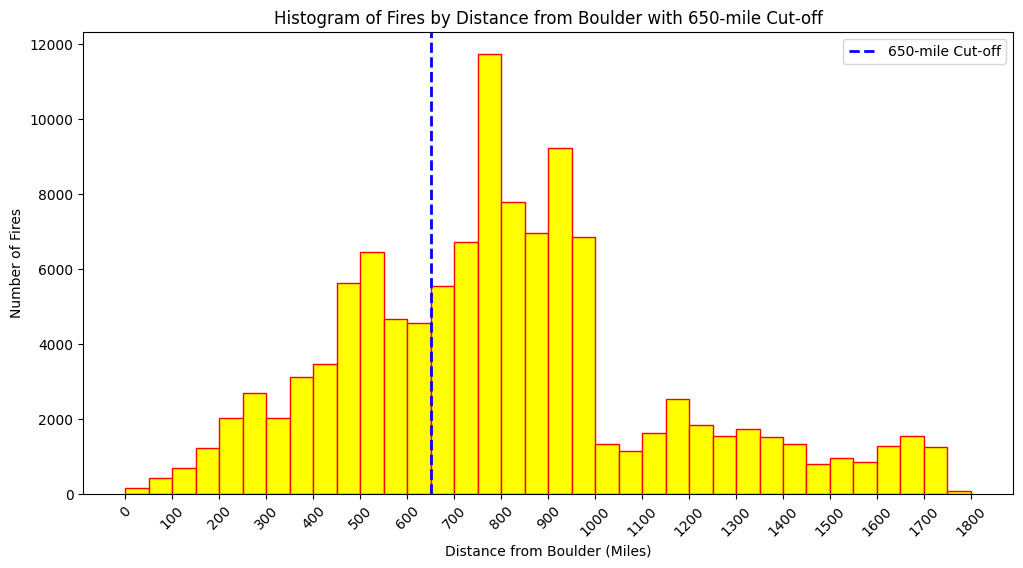

In [77]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the 1800-mile radius fire data from JSON
input_path = "/Users/radhikasethi/Documents/github/data-512-Final-Project/boulder_1800fires_final.json"
with open(input_path, 'r') as file:
    boulder_1800fires_data = json.load(file)

# Convert data to a DataFrame
df_all_boulder_fires = pd.DataFrame(boulder_1800fires_data)

# Verify the structure of the DataFrame
print(df_all_boulder_fires.head())

# Plot histogram of fires by distance
plt.figure(figsize=(12, 6))
plt.hist(df_all_boulder_fires['Distance'], bins=range(0, 1850, 50), color="yellow", edgecolor='red')
plt.xlabel('Distance from Boulder (Miles)')
plt.ylabel('Number of Fires')
plt.title('Histogram of Fires by Distance from Boulder with 650-mile Cut-off')

# Add a vertical line at the 650-mile cut-off
plt.axvline(x=650, color='blue', linestyle='--', linewidth=2, label='650-mile Cut-off')
plt.legend()

# Customize x-axis ticks for readability
plt.xticks(range(0, 1850, 100), rotation=45)

# Show the plot
plt.show()


## Visualization 2

In this visualization, we produce a time series graph of the total acres burned per year for fires occurring within a specified distance threshold from Boulder. This plot provides insight into the trends of wildfire activity and the total area affected by fires each year in the region surrounding Boulder.

For this analysis, we use a distance threshold of 650 miles. We filter the data for fires occurring within this distance, then aggregate the burned area by year and plot the results to observe trends over time.


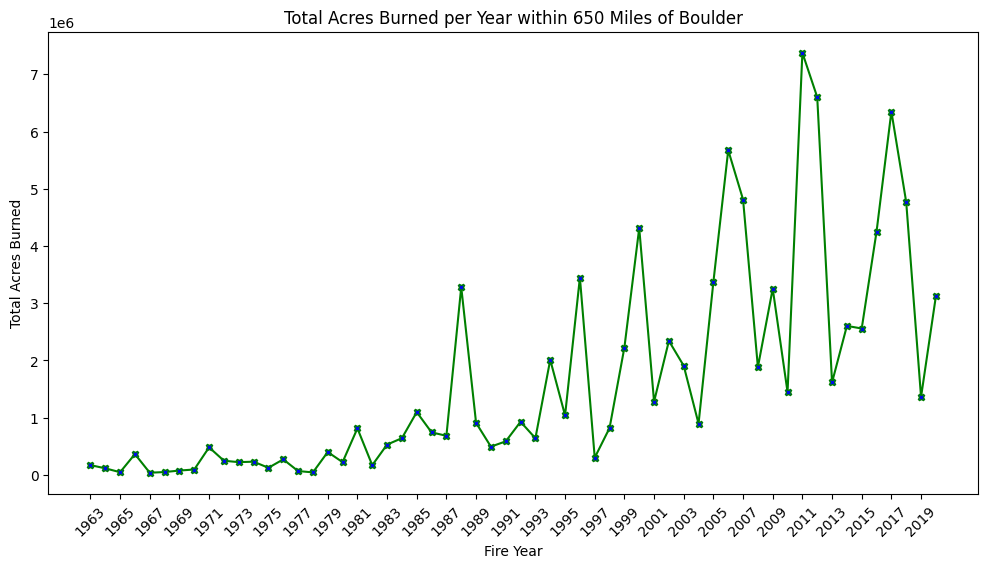

In [79]:
# Set distance threshold
distance_threshold = 650

# Filter for fires within the specified distance threshold
filtered_df = df_all_boulder_fires[df_all_boulder_fires["Distance"] <= distance_threshold]

# Aggregate total acres burned per year
annual_acres_burned = filtered_df.groupby('Fire_Year')['GIS_Acres'].sum()

# Plot time series of total acres burned per year
plt.figure(figsize=(12, 6))
plt.plot(
    annual_acres_burned.index, 
    annual_acres_burned.values, 
    color='green', linestyle='-', marker='X', markerfacecolor='blue', markersize=5
)
plt.xlabel('Fire Year')
plt.ylabel('Total Acres Burned')
plt.title(f'Total Acres Burned per Year within {distance_threshold} Miles of Boulder')
plt.xticks(range(min(annual_acres_burned.index), max(annual_acres_burned.index) + 1, 2), rotation=45)
plt.show()


### Visualization 3: Comparison of Fire Smoke Estimate and AQI for Boulder, CO

In this visualization, we compare the estimated smoke impact from wildfires with the Air Quality Index (AQI) for Boulder, CO. The smoke estimate is based on the size of the fire in acres and its proximity to Boulder, calculated using a custom formula. The AQI data represents the air quality over time, aggregated by year.

By plotting both the smoke estimate and AQI over the years, we can observe any potential correlations between wildfire smoke and air quality in Boulder, CO.


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 1.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


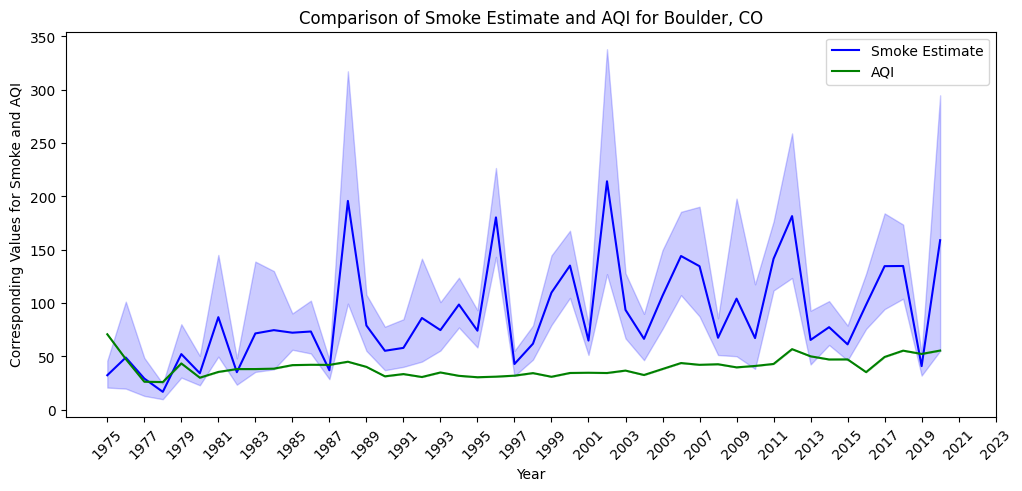

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns

# Paths to the smoke estimate and AQI data files
smoke_data_path = "/Users/radhikasethi/Documents/github/data-512-Final-Project/Smoke_Estimate_Annual.csv"
aqi_data_path = "/Users/radhikasethi/Documents/github/data-512-Final-Project/aqi_yoy.csv"

# Read the smoke estimate and AQI data
smoke_df = pd.read_csv(smoke_data_path)
aqi_df = pd.read_csv(aqi_data_path)

# Rename 'Fire_Year' column in smoke_df to 'Year' for merging
smoke_df.rename(columns={'Fire_Year': 'Year'}, inplace=True)

# Merge data on 'Year' to align smoke estimates and AQI values
merged_df = pd.merge(smoke_df, aqi_df, on='Year')

# Plotting the comparison of Smoke Estimate and AQI
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged_df, x='Year', y='Smoke_Impact', color="blue", label='Smoke Estimate')
sns.lineplot(data=merged_df, x='Year', y='AQI', color="green", label='AQI')
plt.xlabel('Year')
plt.ylabel('Corresponding Values for Smoke and AQI')
plt.title('Comparison of Smoke Estimate and AQI for Boulder, CO')
plt.xticks(range(int(min(merged_df['Year'])), int(max(merged_df['Year'])) + 5, 2), rotation=45)
plt.legend()
plt.show()


In [81]:
# Load the data to inspect columns
smoke_df = pd.read_csv(smoke_data_path)
aqi_df = pd.read_csv(aqi_data_path)

# Display column names
print("Smoke Data Columns:", smoke_df.columns)
print("AQI Data Columns:", aqi_df.columns)


Smoke Data Columns: Index(['Fire_Year', 'GIS_Acres', 'Distance', 'Smoke_Impact'], dtype='object')
AQI Data Columns: Index(['Year', 'AQI'], dtype='object')


## Forecasting

### Step 1: Data Preparation
We prepare the smoke estimate data by setting `Fire_Year` as the index and selecting `Smoke_Impact` as the target variable for time series forecasting. This enables us to leverage ARIMA-based models for forecasting.


In [36]:
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load and prepare the data
smoke_df = pd.read_csv('/Users/radhikasethi/Documents/github/data-512-Final-Project/Smoke_Estimate_Annual.csv')
smoke_df_final = smoke_df[['Fire_Year', 'Smoke_Impact']].rename(columns={'Fire_Year': 'Year', 'Smoke_Impact': 'Smoke_Estimate'})
smoke_df_final.set_index('Year', inplace=True)

In [33]:
!pip3 install pmdarima --quiet


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


###  Fit the SARIMA Model
### Forecasting Future Smoke Estimates for Boulder, CO (650-Mile Wildfires)
In this forecast, we'll employ SARIMA (Seasonal ARIMA) to capture seasonal patterns in the wildfire smoke impact data. SARIMA is a modified ARIMA model that incorporates seasonality, which is particularly helpful for time-series data with periodic trends. Our goal is to predict smoke impact estimates from 2025 to 2050, using a training-validation split to evaluate the model's performance and ensure robust forecasting with confidence intervals.



/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

RMSE: 109614.69061096846


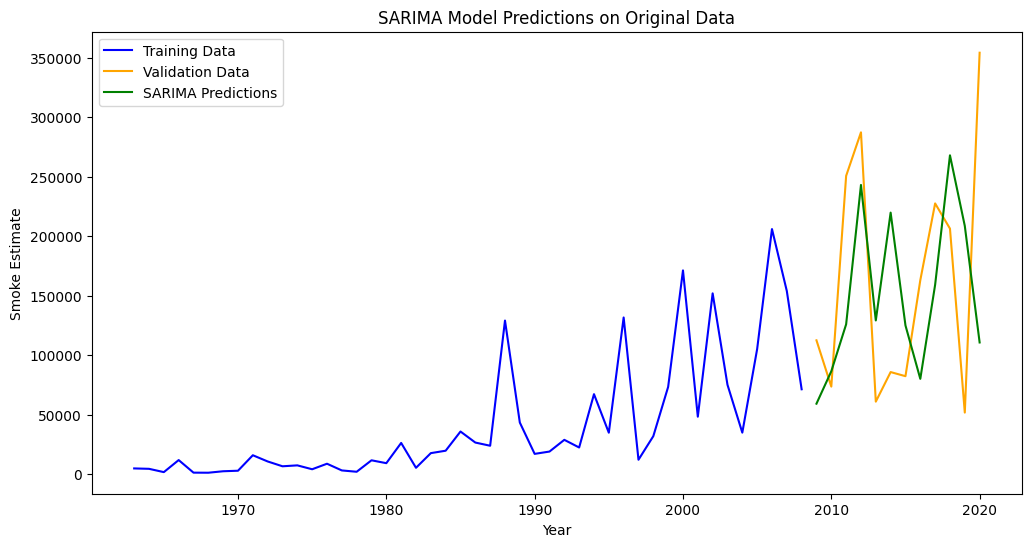

In [43]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Load and prepare the smoke estimate data
smoke_df = pd.read_csv('/Users/radhikasethi/Documents/github/data-512-Final-Project/Smoke_Estimate_Annual.csv')
# Aggregate Smoke_Impact by Fire_Year to get yearly estimates
yearly_smoke_estimate = smoke_df.groupby('Fire_Year')['Smoke_Impact'].sum().reset_index()
yearly_smoke_estimate.rename(columns={'Fire_Year': 'Year', 'Smoke_Impact': 'Smoke_Estimate'}, inplace=True)
yearly_smoke_estimate.set_index('Year', inplace=True)

# Split into train and validation sets
split_index = int(len(yearly_smoke_estimate) * 0.8)
train = yearly_smoke_estimate[:split_index]
valid = yearly_smoke_estimate[split_index:]

# Train SARIMA model on the original (aggregated) data
SARIMA_model = pm.auto_arima(train['Smoke_Estimate'], start_p=1, start_q=1,
                             max_p=3, max_q=3, seasonal=True, m=12, d=None, D=1,
                             start_P=0, test='adf', max_P=3, max_Q=3,
                             trace=False, error_action='ignore',  
                             suppress_warnings=True, stepwise=True)

# Retrieve optimal order from auto_arima
order = SARIMA_model.order
seasonal_order = SARIMA_model.seasonal_order

# Expand train data in each iteration to include one more point from the validation set
sarima_preds = []
for i in range(len(valid)):
    # Use pd.concat to expand the training data
    expanded_train = pd.concat([train['Smoke_Estimate'], valid['Smoke_Estimate'][:i]])
    m_sarima = SARIMAX(expanded_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    sarima_preds.append(m_sarima.forecast(1).values[0])

# Calculate residuals and evaluate model performance
residuals = [x - y for x, y in zip(sarima_preds, valid['Smoke_Estimate'].values)]
rmse = np.sqrt(mean_squared_error(valid['Smoke_Estimate'], sarima_preds))
print(f"RMSE: {rmse}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Smoke_Estimate'], label='Training Data', color='blue')
plt.plot(valid.index, valid['Smoke_Estimate'], label='Validation Data', color='orange')
plt.plot(valid.index, sarima_preds, label='SARIMA Predictions', color='green')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('SARIMA Model Predictions on Original Data')
plt.legend()
plt.show()


with smoothening function applied on the data -- this helps SARIMA with predicting


/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

RMSE: 17688.204185215098


/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


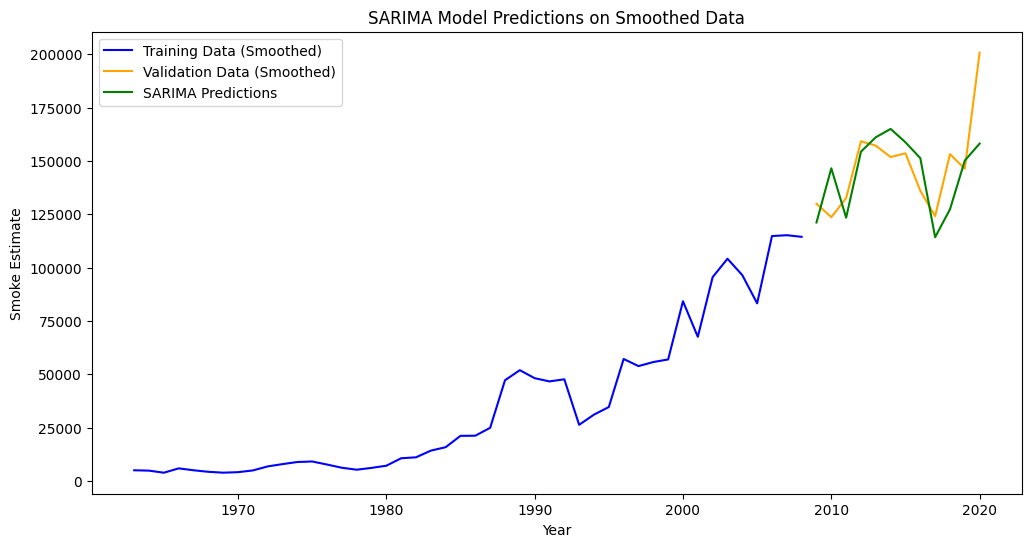

In [42]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Load and prepare the smoke estimate data
smoke_df = pd.read_csv('/Users/radhikasethi/Documents/github/data-512-Final-Project/Smoke_Estimate_Annual.csv')
# Aggregate Smoke_Impact by Fire_Year to get yearly estimates
yearly_smoke_estimate = smoke_df.groupby('Fire_Year')['Smoke_Impact'].sum().reset_index()
yearly_smoke_estimate.rename(columns={'Fire_Year': 'Year', 'Smoke_Impact': 'Smoke_Estimate'}, inplace=True)
yearly_smoke_estimate.set_index('Year', inplace=True)

# Apply a 5-year rolling average to smooth the data
yearly_smoke_estimate['Smoothed_Smoke_Estimate'] = yearly_smoke_estimate['Smoke_Estimate'].rolling(window=5, min_periods=1).mean()

# Split into train and validation sets
split_index = int(len(yearly_smoke_estimate) * 0.8)
train = yearly_smoke_estimate[:split_index]
valid = yearly_smoke_estimate[split_index:]

# Train SARIMA model on smoothed data
SARIMA_model = pm.auto_arima(train['Smoothed_Smoke_Estimate'], start_p=1, start_q=1,
                             max_p=3, max_q=3, seasonal=True, m=12, d=None, D=1,
                             start_P=0, test='adf', max_P=3, max_Q=3,
                             trace=False, error_action='ignore',  
                             suppress_warnings=True, stepwise=True)

# Retrieve optimal order from auto_arima
order = SARIMA_model.order
seasonal_order = SARIMA_model.seasonal_order

# Expand train data in each iteration to include one more point from the validation set
sarima_preds = []
for i in range(len(valid)):
    # Use pd.concat to expand the training data
    expanded_train = pd.concat([train['Smoothed_Smoke_Estimate'], valid['Smoothed_Smoke_Estimate'][:i]])
    m_sarima = SARIMAX(expanded_train, order=order, seasonal_order=seasonal_order).fit(disp=False)
    sarima_preds.append(m_sarima.forecast(1).values[0])

# Calculate residuals and evaluate model performance
residuals = [x - y for x, y in zip(sarima_preds, valid['Smoothed_Smoke_Estimate'].values)]
rmse = np.sqrt(mean_squared_error(valid['Smoothed_Smoke_Estimate'], sarima_preds))
print(f"RMSE: {rmse}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Smoothed_Smoke_Estimate'], label='Training Data (Smoothed)', color='blue')
plt.plot(valid.index, valid['Smoothed_Smoke_Estimate'], label='Validation Data (Smoothed)', color='orange')
plt.plot(valid.index, sarima_preds, label='SARIMA Predictions', color='green')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('SARIMA Model Predictions on Smoothed Data')
plt.legend()
plt.show()



### Comparison of SARIMA Model Predictions on Original and Smoothed Data

This analysis includes two versions of SARIMA model predictions on wildfire smoke estimates for Boulder, CO:

1. **Original Data Forecasting:**
   - In the first plot, we applied the SARIMA model directly to the aggregated yearly smoke estimates.
   - This approach keeps the original variance and noise within the data, allowing for a high level of detail in prediction. However, it can make the forecast line more volatile, as it captures the natural spikes and drops in smoke estimates year-to-year.
   - The green line represents SARIMA predictions on the validation set, compared against the actual values (orange) and training data (blue). While it closely follows the true values, the high variance in the original data can make forecasting challenging.

2. **Smoothed Data Forecasting:**
   - In the second plot, a moving average smoothing technique was applied to the smoke estimate data before fitting the SARIMA model.
   - This smoothing helps reduce extreme fluctuations and makes the data trend more consistent, leading to a forecast that better represents underlying trends over time, rather than abrupt changes.
   - With the smoothed data, the SARIMA model produces a more stable and visually appealing forecast, which may be beneficial for long-term trend predictions.
   
In both models:
- The **Training Data** is shown in blue, representing data used to fit the model.
- **Validation Data** is shown in orange, representing actual observed values for comparison.
- **SARIMA Predictions** appear in green, showing the model's forecasted values on the validation set.

Overall, the choice between using original versus smoothed data depends on the need for detail versus trend stability. The smoothed version provides a clearer indication of overall trends, while the original data model better captures year-to-year fluctuations.

/Users/radhikasethi/Library/Python/3.9/lib/python/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


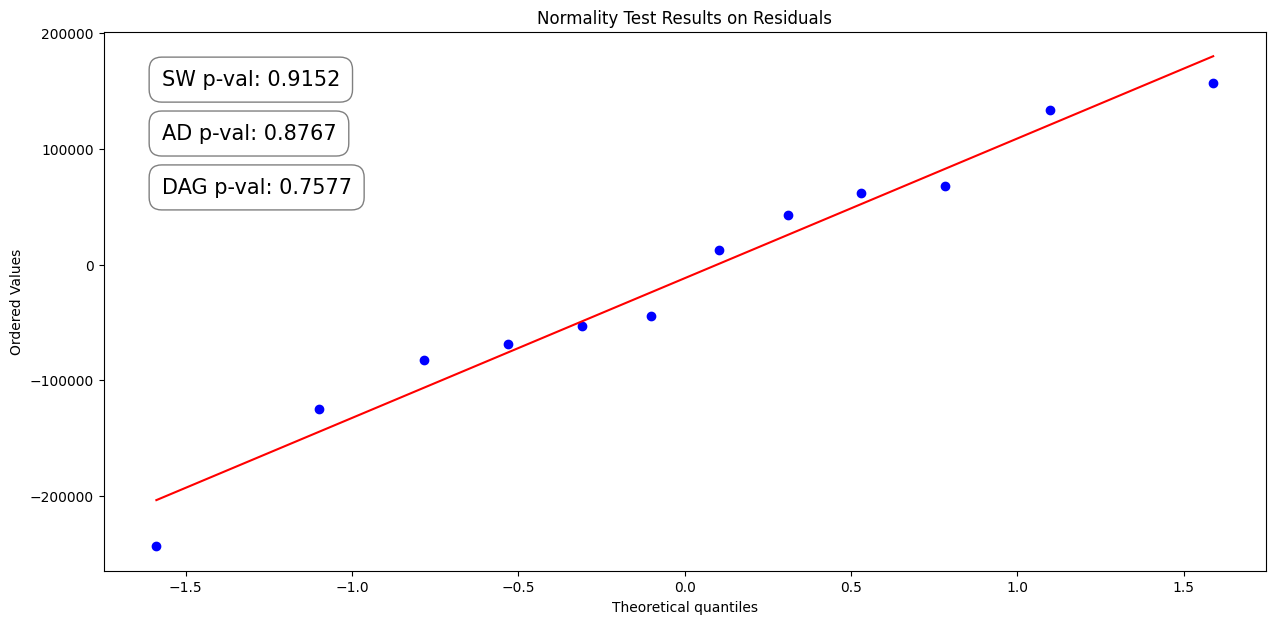

In [44]:
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# Compute residuals
residuals = [x - y for x, y in zip(sarima_preds, valid['Smoke_Estimate'].values)]

# Perform normality tests
sw_result = stats.shapiro(residuals)
ad_result = normal_ad(np.array(residuals), axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

# Plot probability plot of residuals
plt.figure(figsize=(15,7))
stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate(f"SW p-val: {sw_result[1]:.4f}", xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate(f"AD p-val: {ad_result[1]:.4f}", xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate(f"DAG p-val: {dag_result[1]:.4f}", xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
plt.title("Normality Test Results on Residuals")
plt.show()


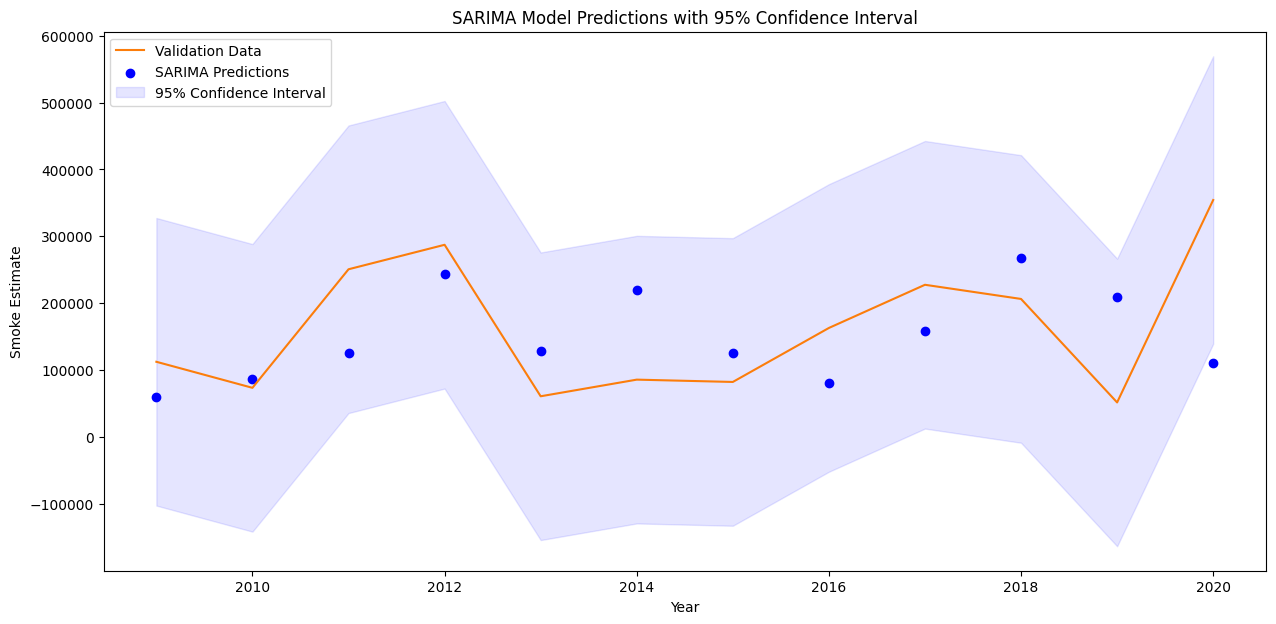

In [45]:
# Calculate RMSFE
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96 * RMSFE  # 95% confidence interval

# Plot validation predictions with confidence intervals
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['Smoke_Estimate'], color='#fc7d0b', label='Validation Data')
ax.scatter(valid.index, sarima_preds, color='blue', label='SARIMA Predictions')
ax.fill_between(valid.index, (valid['Smoke_Estimate'] - band_size), (valid['Smoke_Estimate'] + band_size), 
                color='blue', alpha=0.1, label="95% Confidence Interval")
ax.set_title("SARIMA Model Predictions with 95% Confidence Interval")
ax.set_xlabel('Year')
ax.set_ylabel('Smoke Estimate')
ax.legend()
plt.show()


From above:

### 1. **Normality Test Results on Residuals**

In this plot, we assess whether the residuals (the differences between predicted and actual values) are normally distributed. Three statistical tests are used:
- **Shapiro-Wilk (SW)**, **Anderson-Darling (AD)**, and **D’Agostino’s K-squared (DAG)** tests:
  - These tests calculate p-values that tell us if the residuals deviate significantly from a normal distribution.
  - **Interpretation of p-values**: Since all p-values are above the threshold (0.05), we cannot reject the null hypothesis, indicating the residuals are likely normally distributed. Normality in residuals is a good sign, as it implies that our model errors are distributed in a way that aligns with a well-fitted model.

The accompanying Q-Q plot visually confirms this as the residual points lie close to the red line, which represents the expected distribution if they were perfectly normal. This strengthens our confidence in the SARIMA model’s residual behavior.

---

### 2. **SARIMA Model Predictions with 95% Confidence Interval**

This plot shows the SARIMA model’s predicted values compared to the actual validation data from the year **2010 to 2020**, with a 95% confidence interval shaded in light blue:
- **Orange Line**: Represents the actual smoke impact values for the validation period.
- **Blue Dots**: The SARIMA model's predictions for each year within the validation period.
- **Confidence Interval (shaded region)**: The interval around each prediction that indicates the uncertainty range, where we are 95% confident that the actual value will fall.

The **95% confidence interval** illustrates how confident we are in each prediction. The wider the interval, the greater the uncertainty. In this case, the wide intervals suggest variability in smoke impact, making precise forecasting challenging. However, the model does track the general trend of the validation data, which supports the model's usefulness for long-term forecasting, albeit with some uncertainty.

---

### Summary
These analyses offer insights into the reliability of the SARIMA model for forecasting wildfire smoke impacts. The normality tests indicate a well-fitted model, as the residuals show a near-normal distribution. The confidence interval plot, while showing some variability, follows the observed data trend, suggesting the SARIMA model provides valuable insights into the general trajectory of smoke impacts over time, albeit with an expected range of error due to inherent variability in wildfire smoke data.

---